In [12]:
import numpy as np
# import pandas as pd
from math import exp
# from math import log
from math import pi
# import plotly
# import scipy.special
import matplotlib.pyplot as plt


## Problem 1

c) $$ W(x) e^{W(x)} - x = 0 $$
$$ \frac{d}{dx} [W(x) e^{W(x)} - x = 0] $$
$$ W'(x) e^{W(x)} + W(x) W'(x) e^{W(x)} - 1 = 0 $$
$$ W'(x) e^{W(x)} [1 + W(x)] = 1 $$
$$ W'(x) = \frac{1}{e^{W(x)} [1 + W(x)]} $$

using $ e^{W(x)} = \frac{x}{W(x)} $ 

$$ W'(x) = \frac{W(x)}{x (1 + W(x))} $$

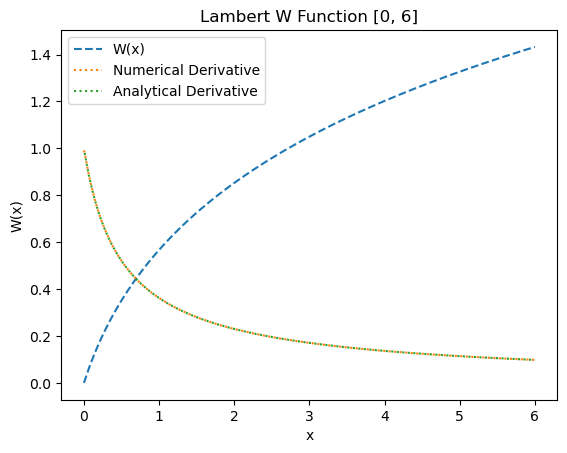

In [13]:
percent_error = lambda m, t: abs(round(((m - t) / t) * 100, 2))
percent_diff = lambda m1, m2: round((m1 - m2) / (0.5*(m1 + m2)), 2)


def bisectional_method(func, lbound: float, rbound: float, *args, tolerance: float = 10**-10, max_iters: int = 100_000, **kwargs):
    '''
    Method to find roots via bisectional method.

    This time I should have remembered to put the tolerance at 10**-10, not 10**10
    '''
    midpoint = lambda p1, p2: (p1 + p2) / 2

    fl = func(lbound, *args, **kwargs)
    fr = func(rbound, *args, **kwargs)

    if ((fl * fr) > 0.):
        return None

    for _ in range(max_iters + 1):
        c = midpoint(lbound, rbound)
        fc = func(c, *args, **kwargs)

        if (fc * fl < 0.):
            rbound = c
            fr = fc
        else:
            lbound = c
            fl = fc

        if ((rbound - lbound) < tolerance):
            return midpoint(lbound, rbound)
    
    else:
        return None


def relaxation_method(f, guess: int or float, tolerance: float = 10**-10, max_iterations = 200, 
                      *args, **kwargs) -> float:
    '''
    Relaxation method for finding roots.

    Takes a function as an input (f), an inital guess (int or float), and will return a float for the root.

    Will, by default, only do 200 iterations, but can be adjusted. Tolerance for success if 10**-10 by default.

    Args and kwargs are used for additional inputs of the function.
    '''
    xprev = xnext = guess

    for i in range(max_iterations):
        # print(xnext)
        xprev = xnext
        xnext = f(xprev, *args, **kwargs)

        if (abs(xnext - xprev) < tolerance):
            return xnext

    else:
        print(f"Failed to converge after {max_iterations} iterations")
        print(f"Values are:\n\tInitial guess = {guess}\n\tXprevious = {xprev}\n\tXnext = {xnext}\n\tError = {abs(xnext - xprev)}")

        return xnext


def df(nfun: dict) -> dict:
    '''
    A method that mixes the df front, back and central method for differentiation. Assumes the x-y pair
    is in order of ascending x.

    The first point uses front method and the last point uses the back method. Points in between
    use the central method.
    '''
    x_values = tuple(nfun.keys())
    y_values = tuple(nfun.values())
    diff = {}

    for i, (x, y) in enumerate(nfun.items()):
        if i == 0:
            h = x_values[i + 1] - x
            fh = y_values[i + 1]

            dfdx = (fh - y) / h
            diff[x] = dfdx
        
        elif i == len(nfun) - 1:
            h = x - x_values[i - 1]
            fh = y_values[i - 1]

            dfdx = (y - fh) / h
            diff[x] = dfdx
        
        else:
            try:
                h = x_values[i + 1] - x_values[i - 1]
                fh = y_values[i + 1] - y_values[i - 1]

                dfdx = fh / h
                diff[x] = dfdx

            except Exception as e:
                print(type(e))
                print(e)
                print(i)
                break

    return diff



lambertW = lambda w, x: w*exp(w) - x
dambertW = lambda w, x: w / (x * (1 + w))

x_range = [i/100 for i in range(0, 601)]
# Note: this uses the bisectional method for all by x = 0, where it uses the relaxation method because 
# it's not possible to bracket the root at x = 0
Wx_Table = [bisectional_method(lambertW, -10, 10, x = i) if i > 0 else relaxation_method(lambertW, -0.00001, x = 0) for i in x_range]

Wx_Table = dict(zip(x_range, Wx_Table))

dWx_Table = df(Wx_Table)

dWx_Analy = {}
for x, w in Wx_Table.items():
    try:
        dWx_Analy[x] = dambertW(w, x)
    except ZeroDivisionError:
        dWx_Analy[x] = np.inf
    except Exception as e:
        print(type(e))
        print(x, w)

plt.title(f"Lambert W Function [0, 6]")
plt.xlabel("x")
plt.ylabel("W(x)")
plt.plot(Wx_Table.keys(), Wx_Table.values(), "--", label = "W(x)")
plt.plot(dWx_Table.keys(), dWx_Table.values(), ":", label = "Numerical Derivative")
plt.plot(dWx_Analy.keys(), dWx_Analy.values(), ":", label = "Analytical Derivative")
plt.legend()
plt.show()

## Problem 2

a) $$ \sum_{i=1}^3 I_i = 0 $$
for $V_2$, incoming currents from Diode and voltage drop across $R_3$, and outgoing current goes across $R_4$:
$$ \frac{V_2 - V_+}{R_3} + \frac{V_2}{R_4} - I_0 [exp(\frac{V_1 - V_2}{V_t}) - 1] = 0 $$
Given for $V_1$:
$$ \frac{V_1 - V_+}{R_1} + \frac{V_1}{R_2} + I_0 [exp(\frac{V_1 - V_2}{V_t}) - 1] = 0 $$

In [14]:
def systemsOfEquations(v: np.array, vT = 0.05, vp = 5.0, r1 = 1000, r2 = 4000, r3 = 3000, r4 = 2000, i0 = 3*10**-9):
    '''
    Function representing the system of equations

    0 = (V1 - V+) / R1 + (V1 / R2) + I0 [exp((V1 - V2) / Vt) - 1]
    0 = (V2 - V+) / R3 + (V2 / R4) - I0 [exp((V1 - V2) / Vt) - 1]

    '''
    f = ((v[0] - vp)/r1) + (v[0] / r2) + (i0 * (exp((v[0] - v[1]) / vT) - 1))
    g = ((v[1] - vp)/r3) + (v[1] / r4) - (i0 * (exp((v[0] - v[1]) / vT) - 1))

    return np.array([f, g])



def jacobian(v: np.array, vT = 0.05, r1 = 1000, r2 = 4000, r3 = 3000, r4 = 2000, i0 = 3*10**-9):
    '''
    Function representing the Jacobian to the System of Equations.
    '''
    dfv1 = (1/r1) + (1/r2) + ((i0 / vT) * (exp((v[0] - v[1]) / vT)))
    dfv2 = - ((i0 / vT) * (exp((v[0] - v[1]) / vT)))
    dgv1 = - ((i0 / vT) * (exp((v[0] - v[1]) / vT)))
    dgv2 = (1/r3) + (1/r4) + ((i0 / vT) * (exp((v[0] - v[1]) / vT)))

    return np.array([[dfv1, dfv2], [dgv1, dgv2]])


def newton_method_vect(func, jacobian, x0: np.array, accuracy: float = 10**-8, max_iterations: int = 1000,
                       *args, **kwargs):
    '''
    Function for calculating system of equations. Takes in a function and a Jacobian, the latter of which needs to be
    turned into it's own function.
    '''

    x = x0

    for _ in range(max_iterations):
        f = func(x, *args, **kwargs)
        j = jacobian(x, *args, **kwargs)
        j = np.linalg.inv(j)

        delta = np.dot(j, -f)

        x = x + delta

    if np.linalg.norm(delta, ord = 2) < accuracy:
        return x

    else:
        return x


v = np.array([0, 0])

roots = newton_method_vect(systemsOfEquations, jacobian, v)
vdiode = abs(roots[0] - roots[1])
print(f"b) V1 = {roots[0]} & V2 = {roots[1]}")
print(f"c) V diode = {vdiode}, which is {percent_diff(vdiode, 0.6)}% difference from the 'rule of thumb' of V = 0.6")


b) V1 = 3.4469546188585745 & V2 = 2.8295680717121385
c) V diode = 0.6173865471464359, which is 0.03% difference from the 'rule of thumb' of V = 0.6


## Problem 3

a) The use of the Romberg method would be impossible due to the limits of integration: because it goes from $\int_0^\frac{\theta}{T} f(x)dx$ the lower limit of 0 results in a singularity when $f(x) = \frac{x^4 e^x}{(e^x - 1)^2} $

Using T = 428 for parts a) and b) (meaning the limits of integration are from 0 to 1:)
Gaussian Integral for T/theata = 1: 2372.771001378933
Adaptive Rectangular Integral for T/theata = 1: 2372.770949934408


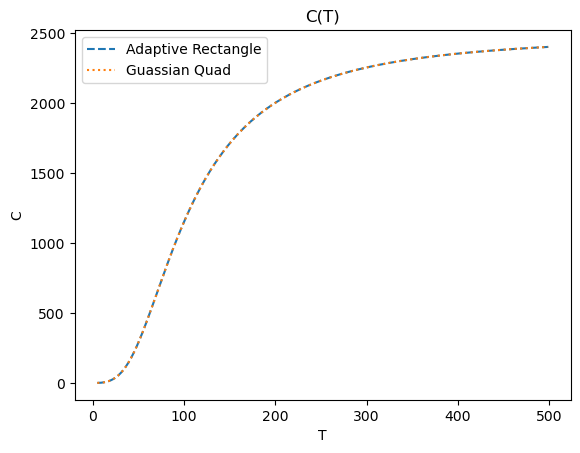

In [15]:
def rectangular_rule(func, lower: float, upper: float, n: int, *args, **kwargs):
    '''
    '''
    h = (upper - lower) / n

    rectangle = 0.0

    xk = lower + h / 2.

    for _ in range(n):
        rectangle += func(xk, *args, **kwargs) * h
        xk += h

    return rectangle


def adaptive_rectangle(func, lower: float, upper: float, *args, n: int = 1, tolerance: float = 10**-8, max_iterations: int = 100, **kwargs):
    '''
    Adaptive rectangular method for calculating an integral. References the Rectangular method, so both need
    to be in the same script
    '''
    
    Ip = rectangular_rule(func, lower, upper, n, *args, **kwargs)

    for _ in range(1, max_iterations):
        n *= 2

        In = rectangular_rule(func, lower, upper, n)
        ek = (In - Ip) / 3.

        if (abs(ek) < tolerance):
            return In

        Ip = In
    
    else:
        return In


def gaussxw(N, epsilon: float = 10**-15, delta: float = 1.0) -> tuple:
    '''
    Returns a tuple of np.ndarray consisting of a N number of points.
    '''
    
    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3, 4 * N - 1, N)/(4 * N + 2)
    x = np.cos(pi * a + 1 / (8 * N * N * np.tan(a)))

    # Find roots using Newton's method
    while delta > epsilon:
        p0 = np.ones(N,float)
        p1 = np.copy(x)
        
        for k in range(1, N):
            p0, p1 = p1, ((2 * k + 1) * x * p1 - k * p0) / (k + 1)
        
        dp = (N + 1) * (p0 - x * p1) / (1 - x * x)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2 * (N + 1) * (N + 1) / (N * N * (1 - x * x) * dp * dp)
    
    return x, w


def gaussian_integration(func, lower: int, upper: int, n_points: int, epsilon: float = 10**-15, delta: float = 1.0,
                         *args, **kwargs):
    '''
    Calculates an integral between the values of a and b using the Guasian Quadrature method.
    '''

    x, w = gaussxw(n_points, epsilon = epsilon, delta = delta)

    x, w = (0.5 * (upper - lower) * x) + (0.5 * (upper + lower)), 0.5 * (upper - lower) * w

    integral = 0.0
    for n in range(n_points):
        integral += w[n]*func(x[n], *args, **kwargs)

    return integral



c_v = lambda x: (x**4 * exp(x)) * (exp(x) - 1)**-2

k: float = 1.38*10**-23
v: float = 1000*10**-6
p: float = 6.022*10**28
thetaD: float = 428.

outer_constant = 9 * v * p * k * thetaD**-3

temps = [t for t in range(5, 500)]

test_temp = 428

g_points = 3
test_gaussian = gaussian_integration(c_v, 0, thetaD / test_temp, 50)
# print(test_gaussian)
print(f"Using T = {test_temp} for parts a) and b) (meaning the limits of integration are from 0 to 1:)")
print(f"Gaussian Integral for T/theata = 1: {outer_constant * (test_temp**3) * test_gaussian}")


test_rectangle = adaptive_rectangle(c_v, 0, thetaD / test_temp, n = 100)
# print(test_integral)
print(f"Adaptive Rectangular Integral for T/theata = 1: {outer_constant * (test_temp**3) * test_rectangle}")

rec_integrals = [(outer_constant * t**3 * adaptive_rectangle(c_v, 0, thetaD / t, n = 100)) for t in temps]
gau_integrals = [(outer_constant * t**3 * gaussian_integration(c_v, 0, thetaD / t, 50)) for t in temps]

c_t_rec = dict(zip(temps, rec_integrals))
c_t_gau = dict(zip(temps, gau_integrals))

plt.title(f"C(T)")
plt.xlabel("T")
plt.ylabel("C")
plt.plot(c_t_rec.keys(), c_t_rec.values(), "--", label = "Adaptive Rectangle")
plt.plot(c_t_gau.keys(), c_t_gau.values(), ":", label = "Guassian Quad")
plt.legend()
plt.show()

## Problem 4

a) $$ W = \frac{\hbar}{4 \pi^2 c^2} \int_0^\infty \frac{\omega^3}{e^(\frac{\hbar \omega}{k T}) - 1}\,d\omega $$

subsituting in
$$ x = \frac{\hbar \omega}{k T} $$
$$ dx = \frac{\hbar}{k T} d\omega $$


yeilds:
$$ W = \frac{\hbar}{4 \pi^2 c^2} (\frac{k T}{\hbar})^{3} (\frac{k T}{\hbar}) \int_0^\infty \frac{x^3}{e^x - 1}\,dx $$

$$ W = \frac{(k T)^4}{4 \pi^2 c^2 \hbar^3}\int_0^\infty \frac{x^3}{e^x - 1}\,dx $$

b) Due to the limits of integration the integral needs to be changed into

$$ \int_0^1 (\frac{t}{(1 - t)})^3 \frac{1}{(1 - t)^2} \frac{1}{e^\frac{t}{1 - t} - 1} dt $$

But because of the possibility of an endpoint singularity, I'm going to evaluate this with the adaptive rectangular method.

In [16]:
black_body = lambda x: x**3 * (exp(x) - 1)**-1
black_tea = lambda t: black_body(t / (1. - t)) / (1. - t)**2

c: float = 3.0*10**8
h: float = 1.054*10**-34  # techically hbar
outside_constant: float = k**4 * (4 * pi**2 * c**2 * h**3)**-1

integral = adaptive_rectangle(black_tea, 0, 1, n = 100)

sb_calc = outside_constant * integral
sb_known = 5.670374419 * 10**-8


print(f"b) Value of Integral = {integral}")
print(f"c) Value for Stefan-Boltzman constnat calculated = {sb_calc}")
print(f"The known value of SB constnat is = {sb_known}\nSo my percent error = {percent_error(sb_calc, sb_known)}%")


b) Value of Integral = 6.4939394022508745
c) Value for Stefan-Boltzman constnat calculated = 5.661095724869131e-08
The known value of SB constnat is = 5.670374419e-08
So my percent error = 0.16%
